In [2]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

from graphviz import Source
from IPython.display import display



import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dowhy.__version__

'0.7.1'

In [4]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

## 1. Matching with a confounder

### Read the data

In [5]:
earnings_data = pd.read_csv(r'./today-data/ml_earnings.csv')

In [9]:
earnings_data.shape

In [10]:
earnings_data.head()

age  took_a_course  earnings
0   19          False  110579.0
1   28          False  142577.0
2   22           True  130520.0
3   25           True  142687.0
4   24          False  127832.0

In [11]:
earnings_data.groupby(['age', 'took_a_course']).mean()

earnings
age took_a_course               
19  False          111110.875000
    True           123488.000000
20  False          115227.142857
    True           125633.285714
21  False          117114.900000
    True           130155.000000
22  False          120226.363636
    True           131437.222222
23  False          124460.900000
    True           134654.333333
24  False          126878.583333
    True           137564.250000
25  False          130812.800000
    True           142715.000000
26  False          134004.250000
    True           144552.800000
27  False          139035.600000
    True           148744.333333
28  False          141580.000000
    True           152485.333333
29  False          145248.600000
    True           152694.000000
30  False          150333.750000
    True           159586.400000
31  False          152532.000000
    True           163592.000000
32  False          157515.200000
    True           169854.000000
33  False          162453.500000
    True           170020.000000
34  False          165694.200000
    True           178922.000000
35  False          172134.250000
    True           180404.500000
36  False          175240.666667
37  False          181514.000000
    True           187627.000000
38  False          185546.333333
39  False          187253.666667
41  False          201729.000000
    True           207676.000000
42  False          203029.000000
    True           214445.000000
43  False          210243.000000
45  True           233035.000000
48  False          239510.000000

In [12]:
# Compute naive estimate 
treatment_avg = earnings_data.query('took_a_course==1')['earnings'].mean()
cntrl_avg = earnings_data.query('took_a_course==0')['earnings'].mean()

treatment_avg - cntrl_avg

### Check True/False Ratio 

In [13]:
earnings_data.query('took_a_course==1')['earnings'].shape[0]/earnings_data.query('took_a_course==0')['earnings'].shape[0]

### Define the graph

In [14]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    print (gml_string)
    
gml_string += ']'

graph [directed 1
	node [id "took_a_course" label "took_a_course"]
	node [id "earnings" label "earnings"]
	node [id "age" label "age"]
	edge [source "took_a_course" target "earnings"]

graph [directed 1
	node [id "took_a_course" label "took_a_course"]
	node [id "earnings" label "earnings"]
	node [id "age" label "age"]
	edge [source "took_a_course" target "earnings"]
	edge [source "age" target "took_a_course"]

graph [directed 1
	node [id "took_a_course" label "took_a_course"]
	node [id "earnings" label "earnings"]
	node [id "age" label "age"]
	edge [source "took_a_course" target "earnings"]
	edge [source "age" target "took_a_course"]
	edge [source "age" target "earnings"]



In [15]:
gml_string

'graph [directed 1\n\tnode [id "took_a_course" label "took_a_course"]\n\tnode [id "earnings" label "earnings"]\n\tnode [id "age" label "age"]\n\tedge [source "took_a_course" target "earnings"]\n\tedge [source "age" target "took_a_course"]\n\tedge [source "age" target "earnings"]\n]'

In [16]:
network_G = nx.parse_gml(gml_string)
graphiz_dot = nx.nx_agraph.to_agraph(network_G)

In [17]:
# Instantiate the CausalModel 
model = CausalModel(
    data=earnings_data,
    treatment='took_a_course',
    outcome='earnings',
    graph=gml_string
)


In [18]:
model.view_model()

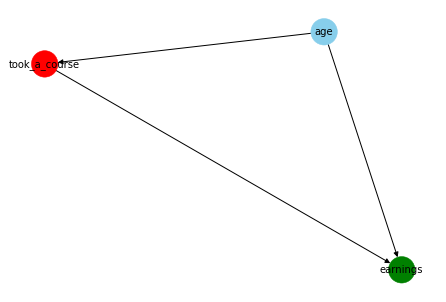

In [19]:
G = nx.parse_gml(gml_string)

# Draw the graph using Matplotlib
node_colors = ["red", "green", "skyblue"]
pos = nx.spring_layout(G)  # You can use different layout algorithms
nx.draw(G, pos, with_labels=True, node_size=700, node_color=node_colors, font_size=10)
plt.show()

### Get the estimand

In [20]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimate the effect
Treatment is a binary

In [21]:
# Get estimate (Matching)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2})

distance_matching


In [22]:
estimate.value

### Refute
1. random common cause

In [23]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='random_common_cause')

In [24]:
print(refutation)

Refute: Add a random common cause
Estimated effect:10333.75
New effect:10347.65895
p value:0.5



### Refute
2. Placebo treatment 

In [25]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name="placebo_treatment_refuter", placebo_type="permute")

In [26]:
# p value is still greater than 0.05, our null hypothesis is good (alternative one is bad)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:10333.75
New effect:-248.98155
p value:0.39



### Refute
3. Data subset refuter

In [27]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name="data_subset_refuter", subset_fraction=0.9)

In [28]:
print(refutation)

Refute: Use a subset of data
Estimated effect:10333.75
New effect:10352.226999999999
p value:0.5



### Summary:
None of retuter beat our null hypothesis which means that ....

### A friendly text interpreter, for ATE

In [29]:
# Textual Interpreter
interpretation = estimate.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [took_a_course] from 0 to 1 causes an increase of 10333.75 in the expected value of the outcome [earnings], over the data distribution/population represented by the dataset.


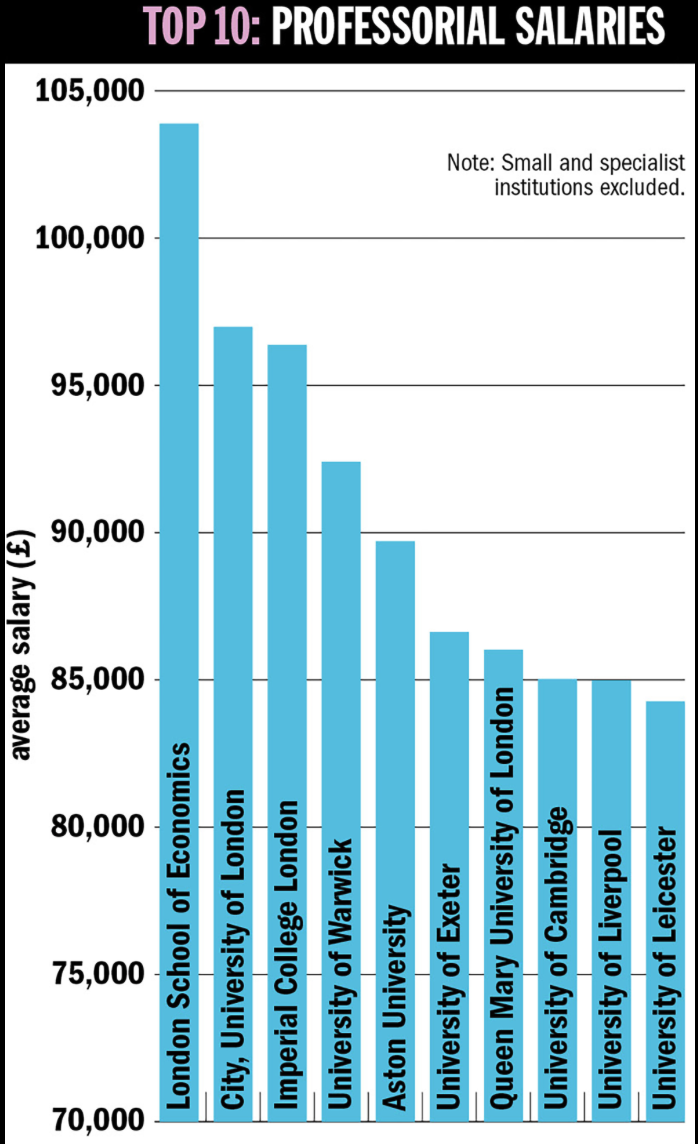

In [30]:
from IPython import display
display.Image("today-data/salary.png")

## 2. Maching with multiple confounders

In [27]:
data = dowhy.datasets.linear_dataset(beta=1,
        num_common_causes=5,
        num_instruments = 2,
        num_treatments=1,
        num_discrete_common_causes=1,
        num_samples=10000,
        treatment_is_binary=True,
        outcome_is_binary=False)

In [28]:
data

{'df':        Z0        Z1        W0        W1        W2        W3 W4     v0  \
 0     0.0  0.555322 -1.689626  2.263640 -1.674799  1.062802  1   True   
 1     1.0  0.943301  1.051261 -0.358150 -1.333713  0.273681  2   True   
 2     0.0  0.188766  0.661592  1.377648 -2.315685 -0.718322  3  False   
 3     1.0  0.321436 -0.277010  1.988405 -1.112679  1.415703  3   True   
 4     0.0  0.735649  0.599711  0.220892 -1.547200  2.462520  1   True   
 ...   ...       ...       ...       ...       ...       ... ..    ...   
 9995  1.0  0.927221  0.611752  1.514108 -2.577562 -1.203170  1   True   
 9996  0.0  0.951255 -0.809138 -1.067759 -0.437646  0.735054  1   True   
 9997  1.0  0.197804  1.046549  0.872746 -0.586669 -1.309668  1   True   
 9998  1.0  0.269970 -1.584591  1.613477 -0.922483 -0.400833  1   True   
 9999  1.0  0.481979  0.003547 -2.102582  1.086110  0.033323  3   True   
 
              y  
 0     0.367509  
 1     1.680136  
 2     0.539858  
 3     3.017948  
 4     1.40641

In [29]:
df = data["df"]
df

Z0        Z1        W0        W1        W2        W3 W4     v0  \
0     0.0  0.555322 -1.689626  2.263640 -1.674799  1.062802  1   True   
1     1.0  0.943301  1.051261 -0.358150 -1.333713  0.273681  2   True   
2     0.0  0.188766  0.661592  1.377648 -2.315685 -0.718322  3  False   
3     1.0  0.321436 -0.277010  1.988405 -1.112679  1.415703  3   True   
4     0.0  0.735649  0.599711  0.220892 -1.547200  2.462520  1   True   
...   ...       ...       ...       ...       ...       ... ..    ...   
9995  1.0  0.927221  0.611752  1.514108 -2.577562 -1.203170  1   True   
9996  0.0  0.951255 -0.809138 -1.067759 -0.437646  0.735054  1   True   
9997  1.0  0.197804  1.046549  0.872746 -0.586669 -1.309668  1   True   
9998  1.0  0.269970 -1.584591  1.613477 -0.922483 -0.400833  1   True   
9999  1.0  0.481979  0.003547 -2.102582  1.086110  0.033323  3   True   

             y  
0     0.367509  
1     1.680136  
2     0.539858  
3     3.017948  
4     1.406412  
...        ...  
9995 -0.242066  
9996  0.767570  
9997  1.558361  
9998  0.446652  
9999  3.401497  

[10000 rows x 9 columns]

In [30]:
print(df[df.v0==True].shape[0])
print(df[df.v0==False].shape[0])

8895
1105


In [31]:
ddf = df.copy()

In [32]:
data["treatment_name"]

['v0']

In [33]:
data["outcome_name"]

'y'

In [34]:
data["common_causes_names"]

['W0', 'W1', 'W2', 'W3', 'W4']

In [35]:
data["instrument_names"]

['Z0', 'Z1']

In [36]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data['dot_graph'],
        instruments=data["instrument_names"]
        )


In [37]:
model.view_model()

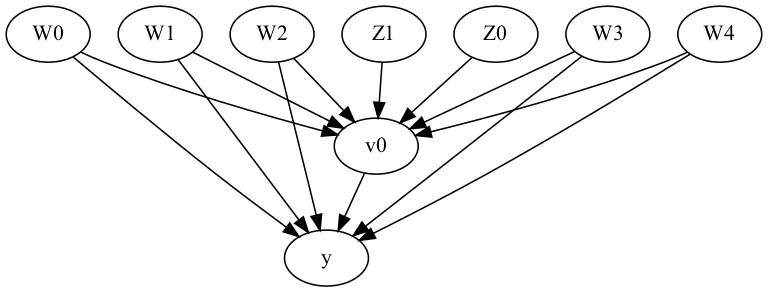

In [38]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

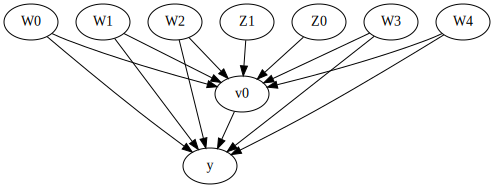

In [39]:
graph = Source(data['dot_graph'], format='png')
display(graph)

### Identify the problems in this network

In [40]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Stratification

### ATT, Propensity score matching

In [41]:
causal_estimate_strat_att = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat_att)
print("Causal Estimate is " + str(causal_estimate_strat_att.value))

propensity_score_stratification


/Users/yongwoojeong/miniforge3/envs/econml/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W4+W3+W2+W0+W1
Target units: att

## Estimate
Mean value: 0.9762043638678443

Causal Estimate is 0.9762043638678443


### ATC, Propensity score matching

In [42]:
causal_estimate_strat_atc = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="atc")
print(causal_estimate_strat_atc)
print("Causal Estimate is " + str(causal_estimate_strat_atc.value))

propensity_score_stratification


/Users/yongwoojeong/miniforge3/envs/econml/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W4+W3+W2+W0+W1
Target units: atc

## Estimate
Mean value: 1.0116685888994934

Causal Estimate is 1.0116685888994934


### ATE, Propensity score matching

In [43]:
causal_estimate_strat_ate = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="ate")
print(causal_estimate_strat_ate)
print("Causal Estimate is " + str(causal_estimate_strat_ate.value))

propensity_score_stratification


/Users/yongwoojeong/miniforge3/envs/econml/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W4+W3+W2+W0+W1
Target units: ate

## Estimate
Mean value: 0.9816214268122391

Causal Estimate is 0.9816214268122391


### A friendly text interpreter, for ATE

In [44]:
# Textual Interpreter
interpretation = causal_estimate_strat_ate.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 0.9816214268122391 in the expected value of the outcome [y], over the data distribution/population represented by the dataset.


## Withtout Stratification. Just Propensity Score Matching

### Propensity score matching (without stratification, accepted broadly but there will be mismatching!)

In [45]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="ate")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

propensity_score_matching


/Users/yongwoojeong/miniforge3/envs/econml/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W4+W3+W2+W0+W1
Target units: ate

## Estimate
Mean value: 1.0369571575560828

Causal Estimate is 1.0369571575560828


### Stratification or Non-Stratification???
Stratification ATE: 1.0231096123399155, 
Non-Stratification ATE: 1.0192327749880936

### Wait, is it imbalanced?

In [46]:
print(df[df.v0==True].shape[0])
print(df[df.v0==False].shape[0])

8895
1105


## Inverse Probability Weighting (IPW)

In [47]:
causal_estimate_ipw_ate = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw_ate)
print("Causal Estimate is " + str(causal_estimate_ipw_ate.value))

propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W4+W3+W2+W0+W1
Target units: ate

## Estimate
Mean value: 1.1850332557838663

Causal Estimate is 1.1850332557838663


/Users/yongwoojeong/miniforge3/envs/econml/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### A friendly text interpreter, for ATE

In [48]:
# Textual Interpreter
interpretation = causal_estimate_ipw_ate.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 1.1850332557838663 in the expected value of the outcome [y], over the data distribution/population represented by the dataset.


### A friendly visual interpreter, for ATE

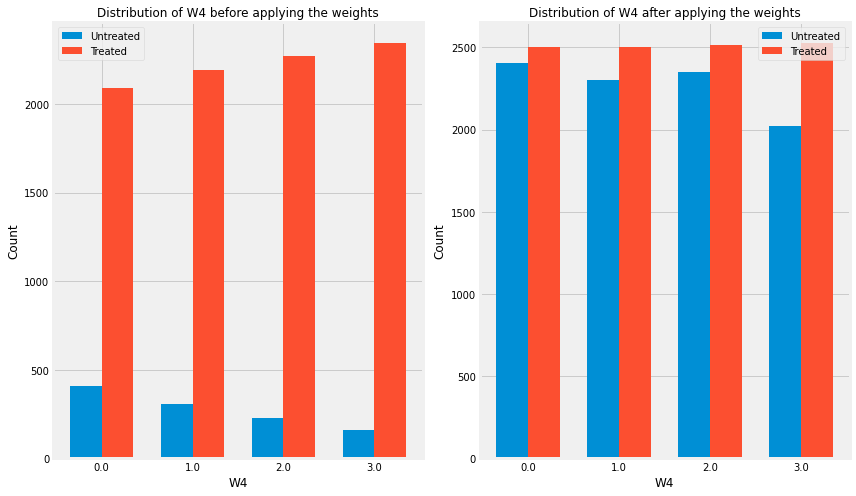

In [49]:
interpretation = causal_estimate_ipw_ate.interpret(method_name="confounder_distribution_interpreter", 
                                        fig_size=(12,7), font_size=12, var_name='W4', var_type='discrete')

### The one Prof. Gary King Likes 

### Mahalanobis distance matching
coarsened exact matching method is only available in R

In [50]:
from scipy.spatial import distance
from scipy.optimize import linear_sum_assignment

In [51]:
# Assume we have the following datasets

treated = pd.DataFrame({
    'age': [25, 32, 47, 51, 34],
    'income': [50000, 64000, 70000, 80000, 62000],
    'outcome': [1, 1, 1, 1, 0],  # Hypothetical outcome variable
    'treatment': [1, 1, 1, 1, 1]  # Indicates these are treatment cases
})

control = pd.DataFrame({
    'age': [23, 35, 45, 55, 38],
    'income': [52000, 66000, 68000, 78000, 60000],
    'outcome': [0, 0, 1, 0, 1],  # Hypothetical outcome variable
    'treatment': [0, 0, 0, 0, 0]  # Indicates these are control cases
})
#

In [52]:
treated

age  income  outcome  treatment
0   25   50000        1          1
1   32   64000        1          1
2   47   70000        1          1
3   51   80000        1          1
4   34   62000        0          1

In [53]:
control

age  income  outcome  treatment
0   23   52000        0          0
1   35   66000        0          0
2   45   68000        1          0
3   55   78000        0          0
4   38   60000        1          0

In [54]:
# Calculate means and covariance matrix from control group
means = control[['age', 'income']].mean()
cov_matrix = control[['age', 'income']].cov()

# Calculate the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Initialize matrix to store the distances
dist_matrix = np.zeros((len(treated), len(control)))

# Calculate Mahalanobis distance between each treatment and control observation
for i in range(len(treated)):
    for j in range(len(control)):
        dist_matrix[i,j] = distance.mahalanobis(treated.iloc[i][['age', 'income']], means, inv_cov_matrix)

# Use linear_sum_assignment to find the optimal pairing
row_ind, col_ind = linear_sum_assignment(dist_matrix)

# Print the optimal pairing
for treatment_ind, control_ind in zip(row_ind, col_ind):
    print(f"Treatment {treatment_ind} is matched with Control {control_ind}")

Treatment 0 is matched with Control 0
Treatment 1 is matched with Control 1
Treatment 2 is matched with Control 2
Treatment 3 is matched with Control 3
Treatment 4 is matched with Control 4


In [55]:
# Select the matched pairs
matched_treatment = treated.iloc[row_ind]
matched_control = control.iloc[col_ind]

# Calculate the ATE
ATE = matched_treatment['outcome'].mean() - matched_control['outcome'].mean()
print("The Average Treatment Effect (ATE) is:", ATE)

The Average Treatment Effect (ATE) is: 0.4


### Again with Liver Cancer dataset

In [56]:
df = pd.read_csv("today-data/data.csv")
df

ID  year  sex  age  drk_st  drk_freq  HBV  HCV  exercise  LC
0        1  2018    1   80       1         2    0    0         0   0
1        2  2018    1   78       1         5    0    0         0   0
2        3  2018    2   75       0         1    0    1         0   0
3        4  2018    2   43       1         4    0    0         3   0
4        5  2018    2   80       0         1    0    0         0   0
...    ...   ...  ...  ...     ...       ...  ...  ...       ...  ..
5973  5974  2018    1   41       1         5    0    0         0   0
5974  5975  2018    2   35       1         4    0    0         0   0
5975  5976  2018    2   66       1         3    0    0         0   0
5976  5977  2018    2   73       0         1    0    0         0   0
5977  5978  2018    1   43       1         5    0    0         0   0

[5978 rows x 10 columns]

In [57]:
df[df.LC==1].shape

In [58]:
df[df.LC==0].shape

In [59]:
df[df.LC==1]

ID  year  sex  age  drk_st  drk_freq  HBV  HCV  exercise  LC
521    522  2018    1   68       1         6    1    0         0   1
2716  2717  2018    1   78       1         1    1    0         0   1
3663  3664  2018    1   63       1         3    1    0         0   1
3694  3695  2018    2   73       1         1    1    0         0   1
5178  5179  2018    2   51       1         4    1    0         0   1
5179  5180  2018    1   63       0         1    0    0         0   1
5411  5412  2018    1   64       1         1    0    0         0   1
5468  5469  2018    1   59       1         6    0    0         0   1

In [60]:
df.drop('ID', axis=1, inplace=True)
df.drop('year', axis=1, inplace=True)

In [61]:
df

sex  age  drk_st  drk_freq  HBV  HCV  exercise  LC
0       1   80       1         2    0    0         0   0
1       1   78       1         5    0    0         0   0
2       2   75       0         1    0    1         0   0
3       2   43       1         4    0    0         3   0
4       2   80       0         1    0    0         0   0
...   ...  ...     ...       ...  ...  ...       ...  ..
5973    1   41       1         5    0    0         0   0
5974    2   35       1         4    0    0         0   0
5975    2   66       1         3    0    0         0   0
5976    2   73       0         1    0    0         0   0
5977    1   43       1         5    0    0         0   0

[5978 rows x 8 columns]

In [62]:
treated=df[df.LC==1].reset_index(drop=True)
treated

sex  age  drk_st  drk_freq  HBV  HCV  exercise  LC
0    1   68       1         6    1    0         0   1
1    1   78       1         1    1    0         0   1
2    1   63       1         3    1    0         0   1
3    2   73       1         1    1    0         0   1
4    2   51       1         4    1    0         0   1
5    1   63       0         1    0    0         0   1
6    1   64       1         1    0    0         0   1
7    1   59       1         6    0    0         0   1

In [63]:
control=df[df.LC==0].reset_index(drop=True)
control

sex  age  drk_st  drk_freq  HBV  HCV  exercise  LC
0       1   80       1         2    0    0         0   0
1       1   78       1         5    0    0         0   0
2       2   75       0         1    0    1         0   0
3       2   43       1         4    0    0         3   0
4       2   80       0         1    0    0         0   0
...   ...  ...     ...       ...  ...  ...       ...  ..
5965    1   41       1         5    0    0         0   0
5966    2   35       1         4    0    0         0   0
5967    2   66       1         3    0    0         0   0
5968    2   73       0         1    0    0         0   0
5969    1   43       1         5    0    0         0   0

[5970 rows x 8 columns]

In [64]:
# Calculate means and covariance matrix from control group
means = control[['sex', 'age', 'drk_st', 'drk_freq', 'HBV', 'HCV', 'exercise']].mean()
cov_matrix = control[['sex', 'age', 'drk_st', 'drk_freq', 'HBV', 'HCV', 'exercise']].cov()

# Calculate the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Initialize matrix to store the distances
dist_matrix = np.zeros((len(treated), len(control)))

# Calculate Mahalanobis distance between each treatment and control observation
for i in range(len(treated)):
    for j in range(len(control)):
        dist_matrix[i,j] = distance.mahalanobis(treated.iloc[i][['sex', 'age', 'drk_st', 'drk_freq', 'HBV', 'HCV', 'exercise']], means, inv_cov_matrix)

# Use linear_sum_assignment to find the optimal pairing
row_ind, col_ind = linear_sum_assignment(dist_matrix)

# Print the optimal pairing
for treatment_ind, control_ind in zip(row_ind, col_ind):
    print(f"Treatment {treatment_ind} is matched with Control {control_ind}")

Treatment 0 is matched with Control 0
Treatment 1 is matched with Control 1
Treatment 2 is matched with Control 2
Treatment 3 is matched with Control 3
Treatment 4 is matched with Control 4
Treatment 5 is matched with Control 5
Treatment 6 is matched with Control 6
Treatment 7 is matched with Control 7


In [65]:
# Select the matched pairs
matched_treatment = treated.iloc[row_ind]
matched_control = control.iloc[col_ind]

# Calculate the ATE
ATE = matched_treatment['exercise'].mean() - matched_control['exercise'].mean()
print("The Average Treatment Effect (ATE) is from LC 1 to 0 is :", ATE)


The Average Treatment Effect (ATE) is from LC 1 to 0 is : -0.375


In [66]:
matched_control

sex  age  drk_st  drk_freq  HBV  HCV  exercise  LC
0    1   80       1         2    0    0         0   0
1    1   78       1         5    0    0         0   0
2    2   75       0         1    0    1         0   0
3    2   43       1         4    0    0         3   0
4    2   80       0         1    0    0         0   0
5    2   71       1         1    0    0         0   0
6    1   44       1         4    0    0         0   0
7    2   42       1         2    0    0         0   0

In [67]:
matched_treatment

sex  age  drk_st  drk_freq  HBV  HCV  exercise  LC
0    1   68       1         6    1    0         0   1
1    1   78       1         1    1    0         0   1
2    1   63       1         3    1    0         0   1
3    2   73       1         1    1    0         0   1
4    2   51       1         4    1    0         0   1
5    1   63       0         1    0    0         0   1
6    1   64       1         1    0    0         0   1
7    1   59       1         6    0    0         0   1